##### Import Necessary libraries

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#load dataset
data = pd.read_csv(r"C:\Users\thars\Downloads\demand_inventory.csv")
print(data.head())

   Unnamed: 0        Date Product_ID  Demand  Inventory
0           0  2023-06-01         P1      51       5500
1           1  2023-06-02         P1     141       5449
2           2  2023-06-03         P1     172       5308
3           3  2023-06-04         P1      91       5136
4           4  2023-06-05         P1     198       5045


In [3]:
# remove Unnamed column
data = data.drop(columns=["Unnamed: 0"])

In [4]:
# let's visualize demand over time
fig_demand = px.line(data, x="Date",
                     y="Demand",
                     title="Demand Over Time")
fig_demand.show()

In [5]:
# Let's Visualize Inventory Over Time
fig_inventory = px.line(data, x="Date",
                        y="Inventory",
                        title="Inventory Over Time")
fig_inventory.show()

### Demand Forecasting

In [7]:
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d")

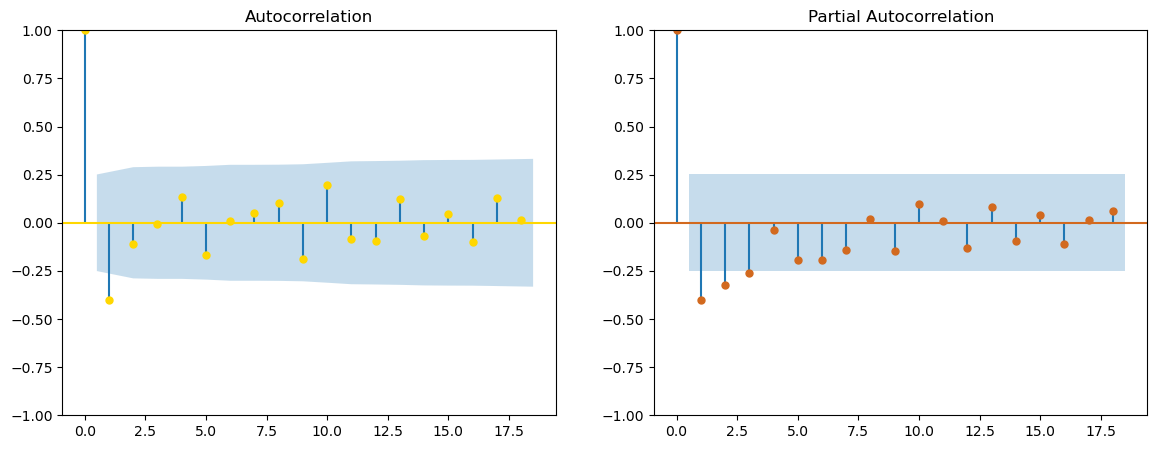

In [8]:
time_series = data.set_index("Date")["Demand"]

differenced_series = time_series.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(differenced_series, ax=axes[0],color="gold")
plot_pacf(differenced_series, ax=axes[1], color="chocolate")

plt.show()

In [10]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2)  #2 because the data contains only 2 months data
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order, freq="D")
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int32


c:\Users\thars\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



##### Inventory Optimization

###### Now let’s see how we can optimize inventory according to the forecasted demand for the next ten days:

In [31]:
# Create date indices for future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq="D")

# Create a pandas Series with predicted values and pandas series
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory Level
initial_inventory = 5500  

# Lead Time (Number of days it takes to replenish inventory)
lead_time = 1  #it's different for every business, 1 is an example

#Service level, (probability of not stocking)
service_level = 0.95 #it's different for every business, 0.95 is an example 

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total_cost(holding cost + stockout cost)
holding_cost = 0.1 #it's different for every business, 0.1 is for example
stockout_cost = 10 #it's different for every business, 10 is for example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calcualte the total cost
total_cost = total_holding_cost + total_stockout_cost

print(f"Optimal Order Quantity: {order_quantity}")
print(f"Reorder Point: {reorder_point}")
print("Safety Stock:", safety_stock)
print(f"Total cost: {total_cost}")

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total cost: 561.8000000000001


In [30]:
safety_stock

114.45

In [18]:
pd.Series(predictions, index=future_dates)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int32

5.000000000000004

0.050000000000000044